<a href="https://colab.research.google.com/github/JoHyunjeong/Deep_learning/blob/main/%EB%94%A5%EB%9F%AC%EB%8B%9D_%EC%8B%A4%EC%8A%B5/5_%20%EC%8B%9C%EA%B3%84%EC%97%B4%20%EC%98%88%EC%B8%A1%20%EB%B0%8F%20%EC%9E%90%EC%97%B0%EC%96%B4%20%EC%B2%98%EB%A6%AC%20%EB%AA%A8%EB%8D%B8%EB%A7%81/Ch03_seq2seq%E1%84%86%E1%85%A9%E1%84%83%E1%85%A6%E1%86%AF%E1%84%8B%E1%85%B3%E1%86%AF_%E1%84%92%E1%85%AA%E1%86%AF%E1%84%8B%E1%85%AD%E1%86%BC%E1%84%92%E1%85%A1%E1%86%AB_%E1%84%8E%E1%85%A2%E1%86%BA%E1%84%87%E1%85%A9%E1%86%BA%E1%84%86%E1%85%A1%E1%86%AB%E1%84%83%E1%85%B3%E1%86%AF%E1%84%80%E1%85%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seq2Seq 모델을 활용한 챗봇 생성

## STEP 1. Seq2Seq 모델의 개요

### 문제 01. seq2seq 모델의 구조에 대한 이해

- encoder & decoder 구조
- 데이터 셋의 구성
- context vector

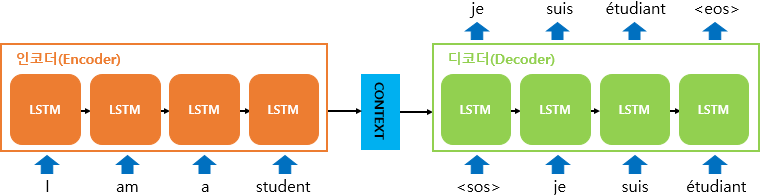

In [1]:
from IPython.display import Image

Image('https://wikidocs.net/images/page/24996/%EC%9D%B8%EC%BD%94%EB%8D%94%EB%94%94%EC%BD%94%EB%8D%94%EB%AA%A8%EB%8D%B8.PNG')

### 문제 02. 데이터셋에 필요한 라이브러리를 다운로드 받습니다.

`Korpora`는 한글 자연어처리 데이터셋입니다.

- [깃헙 주소 링크](https://github.com/ko-nlp/Korpora)
- [공식 도큐먼트](https://pypi.org/project/Korpora/)

설치 명령어

In [2]:
!pip install Korpora

- 이 중 챗봇용 데이터셋인 `KoreanChatbotKorpus`를 다운로드 받습니다.
- `KoreanChatbotKorpus` 데이터셋을 활용하여 챗봇 모델을 학습합니다.
- text, pair로 구성되어 있습니다.
- 질의는 **text**, 답변은 **pair**입니다.

### 문제 03. Korpora의 챗봇 데이터를 import 합니다.

In [3]:
# from Korpora import KoreanChatbotKorpus
# corpus = KoreanChatbotKorpus() # HTTPError

예시 텍스트를 보면 구어체로 구성되어 있습니다.

In [4]:
# corpus.get_all_pairs() # 답변

In [5]:
# corpus.get_all_texts() # 질문

데이터셋 확인

In [6]:
# corpus.get_all_texts()[:5] # 질문

In [7]:
# corpus.get_all_pairs()[:5] # 답변

In [8]:
import pandas as pd

corpus = pd.read_csv('https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv')
corpus.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [9]:
corpus.Q[:5] # 질문

0             12시 땡!
1        1지망 학교 떨어졌어
2       3박4일 놀러가고 싶다
3    3박4일 정도 놀러가고 싶다
4            PPL 심하네
Name: Q, dtype: object

In [10]:
corpus.A[:5] # 답변

0     하루가 또 가네요.
1      위로해 드립니다.
2    여행은 언제나 좋죠.
3    여행은 언제나 좋죠.
4     눈살이 찌푸려지죠.
Name: A, dtype: object

## STEP 2. 데이터 전처리

### 문제 04. quenstion 데이터셋과 answer 데이터셋 분리

**question**과 **answer**를 분리합니다.

**question**은 질의로 활용될 데이터셋, **answer**는 답변으로 활용될 데이터 셋입니다.

In [11]:
# texts = []
# pairs = []

# for text, pair in zip(corpus.get_all_texts(), corpus.get_all_pairs()):
#   texts.append(text)
#   pairs.append(pairs)

In [12]:
texts = []
pairs = []
for i, (text, pair) in enumerate(zip(corpus['Q'], corpus['A'])):
    texts.append(text)
    pairs.append(pair)

In [13]:
list(zip(texts, pairs))[:5]

[('12시 땡!', '하루가 또 가네요.'),
 ('1지망 학교 떨어졌어', '위로해 드립니다.'),
 ('3박4일 놀러가고 싶다', '여행은 언제나 좋죠.'),
 ('3박4일 정도 놀러가고 싶다', '여행은 언제나 좋죠.'),
 ('PPL 심하네', '눈살이 찌푸려지죠.')]

### 문제 05. 특수문자는 제거합니다.

**한글과 숫자를 제외한 특수문자를 제거**하도록 합니다. (선택사항)


[참고] 튜토리얼에서는 특수문자와 영문자를 제거하나, 실제 프로젝트에 적용해보기 위해서는 신중히 결정해야합니다

*챗봇 대화에서 영어도 많이 사용되고, 특수문자도 굉장히 많이 사용됩니다. 따라서, 선택적으로 제거할 특수기호나 영문자를 정의한 후에 전처리를 진행하야합니다.*

In [14]:
# re 모듈은 regex expression을 적용하기 위하여 활용합니다.
import re

In [15]:
def clean_sentence(sentence):
    # 한글, 숫자를 제외한 모든 문자는 제거합니다.
    # 코드를 입력하세요
    sentence = re.sub(r'[^0-9ㄱ-ㅎㅏ-ㅣ가-힣 ]',r'', sentence)
    return sentence

**적용한 예시**

한글, 숫자 이외의 모든 문자를 전부 제거됨을 확인할 수 있습니다.

In [16]:
clean_sentence('12시 땡^^!??')

'12시 땡'

In [17]:
clean_sentence('abcef가나다^^$%@12시 땡^^!??')

'가나다12시 땡'

### 문제 06. 한글 형태소 분석기 (Konlpy)

형태소 분석기를 활용하여 문장을 분리합니다.

```가방에 들어가신다 -> 가방/NNG + 에/JKM + 들어가/VV + 시/EPH + ㄴ다/EFN```

- **형태소 분석** 이란 형태소를 비롯하여, 어근, 접두사/접미사, 품사(POS, part-of-speech) 등 다양한 언어적 속성의 구조를 파악하는 것입니다.
- **konlpy 형태소 분석기를 활용**하여 한글 문장에 대한 토큰화처리를 보다 효율적으로 처리합니다.



[공식 도큐먼트](https://konlpy-ko.readthedocs.io/ko/v0.4.3/morph/)

**설치**

In [18]:
!pip install konlpy

konlpy 내부에는 Kkma, Okt, Twitter 등등의 형태소 분석기가 존재하지만, 이번 튜토리얼에서는 Okt를 활용하도록 하겠습니다.

In [19]:
from konlpy.tag import Okt

In [20]:
# Okt 토크나이저 객체를 생성합니다.
# 코드를 입력하세요
okt = Okt()

In [21]:
# 형태소 변환에 활용하는 함수
# morphs 함수 안에 변환한 한글 문장을 입력 합니다.
def process_morph(sentence):
    return ' '.join(okt.morphs(sentence))

In [22]:
process_morph('한글은 홀소리와 닿소리 모두 소리틀을 본떠 만든 음소문자[1]로 한글 맞춤법에서는 닿소리 14개와 홀소리 10개, 모두 24개를 표준으로 삼는다. "나랏말이 중국과 달라" 문제를 느낀 조선의 세종대왕이 한국어는 물론 이웃나라 말까지 나타내도록 1443년 창제하여 1446년 반포하였다. ')

'한글 은 홀소리 와 닿소리 모두 소 리틀 을 본떠 만든 음소문자 [ 1 ] 로 한글 맞춤법 에서는 닿소리 14 개 와 홀소리 10 개 , 모두 24 개 를 표준 으로 삼는다 . " 나랏말 이 중국 과 달라 " 문제 를 느낀 조선 의 세종대왕 이 한국어 는 물론 이웃 나라 말 까지 나타내도록 1443년 창제 하여 1446년 반포 하였다 .'

## STEP 3. 데이터셋 구성

### 문제 07. Seq2Seq 학습을 위한 데이터셋 구성

**Seq2Seq** 모델이 학습하기 위한 데이터셋을 구성할 때, 다음과 같이 **3가지 데이터셋**을 구성합니다.

- `question`: encoder input 데이터셋 (질의 전체)
- `answer_input`: decoder input 데이터셋 (답변의 시작). START 토큰을 문장 처음에 추가 합니다.
- `answer_output`: decoder output 데이터셋 (답변의 끝). END 토큰을 문장 마지막에 추가 합니다.

In [23]:
def clean_and_morph(sentence, is_question=True):
    # 한글 문장 전처리
    sentence = clean_sentence(sentence)
    
    # 형태소 변환
    sentence = process_morph(sentence)
    
    # Question 인 경우, Answer인 경우를 분기하여 처리합니다.
    if is_question:
        return sentence
    else:
        # START 토큰은 decoder input에 END 토큰은 decoder output에 추가합니다.
        return ('<START> ' + sentence, sentence + ' <END>')

### 문제 08. preprocess 함수에서는 `text`와 `pair`에 대한 데이터 셋 구성을 진행합니다.

In [24]:
def preprocess(texts, pairs):
    questions = [] # encoder 입력
    answer_in = [] # decoder 입력
    answer_out = [] # decoder 출력(답)

    # 질의에 대한 전처리
    for text in texts:
        # 전처리와 morph 수행
        question = clean_and_morph(text, is_question = True)
        questions.append(question)

    # 답변에 대한 전처리
    for pair in pairs:
        # 전처리와 morph 수행
        # 코드를 입력하세요
        in_, out_ = clean_and_morph(pair, is_question = False)
        answer_in.append(in_)
        answer_out.append(out_)
    
    return questions, answer_in, answer_out

In [25]:
# questions, answer_in, answer_out = preprocess(texts, pairs)

# 15번에서 RAM 초과 에러 시 -> data 2000개 씩 사용으로 수정
texts = texts[:2000]
pairs = pairs[:2000]
questions, answer_in, answer_out = preprocess(texts, pairs)

In [26]:
questions[:5]

['12시 땡', '1 지망 학교 떨어졌어', '3 박 4일 놀러 가고 싶다', '3 박 4일 정도 놀러 가고 싶다', '심하네']

In [27]:
answer_in[:5]

['<START> 하루 가 또 가네요',
 '<START> 위로 해 드립니다',
 '<START> 여행 은 언제나 좋죠',
 '<START> 여행 은 언제나 좋죠',
 '<START> 눈살 이 찌푸려지죠']

In [28]:
answer_out[:5]

['하루 가 또 가네요 <END>',
 '위로 해 드립니다 <END>',
 '여행 은 언제나 좋죠 <END>',
 '여행 은 언제나 좋죠 <END>',
 '눈살 이 찌푸려지죠 <END>']

### 문제 09. `all_sentences` 변수에 모든 데이터셋 문장을 합칩니다.

합치는 이유는 모든 문장을 합쳐서 토큰화를 진행하기 위함입니다.

In [29]:
all_sentences = questions + answer_in + answer_out

In [30]:
a = (' '.join(questions) + ' '.join(answer_in) + ' '.join(answer_out)).split()
len(set(a)) # 고유 단어만 남김

3605

## STEP 4. 토큰화 (Tokenizer)

In [31]:
import numpy as np
import warnings
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# WARNING 무시
warnings.filterwarnings('ignore')

### 문제 10. 토근의 option을 정의 합니다.

- filter는 ''로 지정합니다.(빈 문자열) -> 빈 문자열 기준으로 토큰화  
- lower는 False로 지정합니다.
- oov_token(out of vocab token)은 '\<OOV>'로 지정합니다.

**토큰의 정의**

In [32]:
tokenizer = Tokenizer(filters='', lower=False, oov_token='<OOV>')

### 문제 11. 단어 사전을 만듭니다.

**Tokenizer**로 문장에 대한 Word-Index Vocabulary(단어 사전)을 만듭니다.

In [33]:
tokenizer.fit_on_texts(all_sentences)

**단어 사전 10개 출력**

In [34]:
for word, idx in tokenizer.word_index.items():
    print(f'{word}\t\t => \t{idx}')
    if idx > 10:
        break

<OOV>		 => 	1
<START>		 => 	2
<END>		 => 	3
이		 => 	4
을		 => 	5
거		 => 	6
가		 => 	7
예요		 => 	8
도		 => 	9
해보세요		 => 	10
요		 => 	11


### 문제 12. 토큰의 갯수 지정

**토큰의 갯수 확인**

In [35]:
print(len(tokenizer.word_index))
# VOCAB_SIZE 변수에 토큰의 단어 사전의 갯수를 입력합니다.
VOCAB_SIZE = len(tokenizer.word_index) + 1 # padding을 추가할 예정이기 때문에 1 더해줌

3604


### 문제 13. 치환: 텍스트를 시퀀스로 인코딩 (`texts_to_sequences`)

In [36]:
question_sequence = tokenizer.texts_to_sequences(questions)
answer_in_sequence = tokenizer.texts_to_sequences(answer_in)
answer_out_sequence = tokenizer.texts_to_sequences(answer_out)

In [37]:
questions[0]

'12시 땡'

In [38]:
question_sequence[0]

[1757, 2494]

In [39]:
answer_in[0]

'<START> 하루 가 또 가네요'

In [40]:
answer_in_sequence[0]

[2, 366, 7, 128, 1057]

In [41]:
tokenizer.word_index['하루']

366

### 문제 14. 문장의 길이 맞추기 (`pad_sequences`)

`pad_sequences`를 활용하여 문장의 길이를 맞춰 줍니다.

In [42]:
# 최대 문자의 토큰 갯수는 30개로 지정합니다.
MAX_LENGTH = 30 # 한 문장에 들어가는 최대 단어 개수
TRUNCATING = 'post' # 문장의 뒷 부분을 잘라냄 'post' / 앞 부분은 'pre'
PADDING = 'post' # 문장의 뒷 부분을 채워줌 'post' / 앞 부분은 'pre'

In [43]:
question_padded = pad_sequences(question_sequence, maxlen=MAX_LENGTH, truncating=TRUNCATING, padding=PADDING)
answer_in_padded = pad_sequences(answer_in_sequence, maxlen=MAX_LENGTH, truncating=TRUNCATING, padding=PADDING)
answer_out_padded = pad_sequences(answer_out_sequence, maxlen=MAX_LENGTH, truncating=TRUNCATING, padding=PADDING)

변환된 데이터 셋의 shape를 확인합니다.

In [44]:
question_padded.shape

(2000, 30)

In [45]:
answer_in_padded.shape, answer_out_padded.shape

((2000, 30), (2000, 30))

In [46]:
question_padded[0]

array([1757, 2494,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [47]:
answer_in_padded[0]

array([   2,  366,    7,  128, 1057,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [48]:
answer_out_padded[0]

array([ 366,    7,  128, 1057,    3,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

## STEP 5. 데이터셋 변환 함수 정의

### 문제 15. 단어별 원핫인코딩 적용

단어별 원핫인코딩을 적용하는 이유는 decoder의 output(출력)을 원핫인코딩 vector로 변환하기 위함

In [49]:
def convert_to_one_hot(padded):
    # 원핫인코딩 초기화
    one_hot_vector = np.zeros((len(padded), MAX_LENGTH, VOCAB_SIZE)) # (문장 수, 한 문장의 단어 수(=30), 단어사전의 단어 수)

    # 디코더 목표를 원핫인코딩으로 변환
    # 학습시 입력은 인덱스이지만, 출력은 원핫인코딩 형식임
    for i, sequence in enumerate(padded):
      for j, index in enumerate(sequence):
        one_hot_vector[i, j, index] = 1
        
    return one_hot_vector

In [50]:
# RAM 용량이 초과하는 경우 세션이 다운될 수 있습니다.
# 그럴때는 학습 세트의 전체 사이즈를 줄여주세요.
answer_in_one_hot = convert_to_one_hot(answer_in_padded)

In [51]:
answer_out_one_hot = convert_to_one_hot(answer_out_padded)

In [52]:
answer_in_one_hot[0].shape, answer_in_one_hot[0].shape

((30, 3605), (30, 3605))

### 문제 16. 변환된 index를 다시 단어로 변환

In [53]:
def convert_index_to_text(indexs, end_token): 
    
    sentence = ''
    
    # 모든 문장에 대해서 반복
    for index in indexs:
        if index == end_token:
            # 끝 단어이므로 예측 중지
            break;
        # 사전에 존재하는 단어의 경우 단어 추가
        if index > 0 and tokenizer.index_word[index] is not None:
            sentence += tokenizer.index_word[index]
        else:
        # 사전에 없는 인덱스면 빈 문자열 추가
            sentence += ''
            
        # 빈칸 추가
        sentence += ' '
    return sentence

## STEP 6. 모델 생성

모델 생성을 위한 필요한 모듈을 import 합니다.

In [54]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

### 문제 17. 학습용 인코더 (Encoder)

In [55]:
class Encoder(tf.keras.Model):
    def __init__(self, units, vocab_size, embedding_dim, time_steps):
        super(Encoder, self).__init__()
        self.embedding = Embedding(vocab_size, embedding_dim, input_length=time_steps)
        self.dropout = Dropout(0.2) # 과적합 방지 용도
        self.lstm = LSTM(units, return_state=True) # return_state -> context 벡터 만들 때 사용 / state는 hidden state, cell state 두 가지
        
    def call(self, inputs):
        x = self.embedding(inputs)
        x = self.dropout(x)
        x, hidden_state, cell_state = self.lstm(x)

        return [hidden_state, cell_state] # context vector 리턴

### 문제 18. 학습용 디코더 (Decoder)

In [56]:
class Decoder(tf.keras.Model):
    def __init__(self, units, vocab_size, embedding_dim, time_steps):
        super(Decoder, self).__init__()
        self.embedding = Embedding(vocab_size, embedding_dim, input_length=time_steps)
        self.dropout = Dropout(0.2)
        self.lstm = LSTM(units,
                         return_state=True,
                         return_sequences=True,
                         )
        self.dense = Dense(vocab_size, activation='softmax')
    
    def call(self, inputs, initial_state):
        x = self.embedding(inputs)
        x = self.dropout(x)
        x, hidden_state, cell_state = self.lstm(x, initial_state=initial_state) # initial_state는 encoder에서 만든 context vector
        x = self.dense(x)

        return x, hidden_state, cell_state

### 문제 19. Seq2Seq 모델

Seq2Seq 모델은 사전 단계에서 만들어놓은 encoder와 decoder를 활용하여 생성합니다.

In [57]:
class Seq2Seq(tf.keras.Model):
    def __init__(self, units, vocab_size, embedding_dim, time_steps, start_token, end_token):
        super(Seq2Seq, self).__init__()
        self.start_token = start_token
        self.end_token = end_token
        self.time_steps = time_steps # 한 문장의 단어 길이
        
        self.encoder = Encoder(units, vocab_size, embedding_dim, time_steps)
        self.decoder = Decoder(units, vocab_size, embedding_dim, time_steps)
        
    def call(self, inputs, training=True): # training -> True : 학습 / False : 예측
        if training: # 학습
            encoder_inputs, decoder_inputs = inputs
            context_vector = self.encoder(encoder_inputs)
            decoder_outputs, _, _ = self.decoder(inputs=decoder_inputs, initial_state=context_vector)
            return decoder_outputs

        else: # 예측
            context_vector = self.encoder(inputs)
            target_seq = tf.constant([[self.start_token]], dtype=tf.float32) # 한 단어씩 예측 / decoder 입력 첫 단어는 start_token
            results = tf.TensorArray(tf.int32, self.time_steps) # 빈 그릇
            
            for i in tf.range(self.time_steps):
                decoder_output, decoder_hidden, decoder_cell = self.decoder(target_seq, initial_state=context_vector)
                decoder_output = tf.cast(tf.argmax(decoder_output, axis=-1), dtype=tf.int32) # index로 변환 / onehot -> sparse
                decoder_output = tf.reshape(decoder_output, shape=(1, 1))
                results = results.write(i, decoder_output) # 결과 추가
                
                if decoder_output == self.end_token:
                    break
                    
                target_seq = decoder_output
                context_vector = [decoder_hidden, decoder_cell]
                
            return tf.reshape(results.stack(), shape=(1, self.time_steps))

## STEP 7. 학습 (Training)

### 문제 20. 학습을 위한 parameter를 정의하고 체크포인트를 생성합니다.

**하이퍼 파라미터 정의**

In [58]:
BUFFER_SIZE = 1000
BATCH_SIZE = 16 # 하드웨어 여건에 따라 조절
EMBEDDING_DIM = 100
TIME_STEPS = MAX_LENGTH

# 코드를 입력하세요
START_TOKEN = tokenizer.word_index['<START>']
END_TOKEN = tokenizer.word_index['<END>']

UNITS = 128 # lstm에 들어가는 unit 수

# 코드를 입력하세요
VOCAB_SIZE = len(tokenizer.word_index) + 1
DATA_LENGTH = len(questions) # 데이터 개수
SAMPLE_SIZE = 3
NUM_EPOCHS = 20

**체크포인트 생성**

In [59]:
checkpoint_path = './sample-checkpoint.ckpt'
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             save_best_only=True, 
                             save_weights_only=True,
                             monitor='loss', 
                             verbose=1
                            )

### 문제 21. 모델 생성 & compile을 진행합니다.

optimizer는 `adam`, loss는 `categorical_crossentropy`로 지정합니다.

In [60]:
# 코드를 입력하세요
seq2seq = Seq2Seq(units=UNITS, vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, time_steps=TIME_STEPS, start_token=START_TOKEN, end_token=END_TOKEN)
seq2seq.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc']) # onehot -> categorical crossentropy 사용

In [61]:
# (필요시) 연속하여 학습시 체크포인트를 로드하여 이어서 학습합니다.
# seq2seq.load_weights(checkpoint_path)

### 문제 22. make_prediction 함수를 정의 합니다. 예측된 결과를 역 출력 해주기 위한 함수입니다.

In [77]:
def make_prediction(model, question_inputs):
    results = model(inputs=question_inputs, training=False)
    # 변환된 인덱스를 문장으로 변환
    results = np.asarray(results).reshape(-1)
    return results

In [63]:
for epoch in range(NUM_EPOCHS):
    print(f'processing epoch: {epoch * 10 + 1}...')
    # model.fit(): 학습
    # 코드를 입력하세요
    seq2seq.fit([question_padded, answer_in_padded], # inputs
                answer_out_one_hot, # outputs
                epochs=10,
                batch_size=BATCH_SIZE,
                callbacks=[checkpoint]
               )
    # 랜덤한 샘플 번호 추출
    samples = np.random.randint(DATA_LENGTH, size=SAMPLE_SIZE)

    # 예측 성능 테스트
    for idx in samples:
        question_inputs = question_padded[idx]
        # 문장 예측
        results = make_prediction(seq2seq, np.expand_dims(question_inputs, 0))
        
        # 변환된 인덱스를 문장으로 변환
        results = convert_index_to_text(results, END_TOKEN)
        
        print(f'Q: {questions[idx]}')
        print(f'A: {results}\n')
        print()

processing epoch: 1...
Epoch 1/10
122/125 [============================>.] - ETA: 0s - loss: 2.4456 - acc: 0.7982
Epoch 1: loss improved from inf to 2.41877, saving model to ./sample-checkpoint.ckpt
125/125 [==============================] - 7s 14ms/step - loss: 2.4188 - acc: 0.7983
Epoch 2/10
121/125 [============================>.] - ETA: 0s - loss: 1.2115 - acc: 0.8163
Epoch 2: loss improved from 2.41877 to 1.20989, saving model to ./sample-checkpoint.ckpt
125/125 [==============================] - 1s 11ms/step - loss: 1.2099 - acc: 0.8166
Epoch 3/10
121/125 [============================>.] - ETA: 0s - loss: 1.1092 - acc: 0.8370
Epoch 3: loss improved from 1.20989 to 1.11064, saving model to ./sample-checkpoint.ckpt
125/125 [==============================] - 1s 11ms/step - loss: 1.1106 - acc: 0.8368
Epoch 4/10
121/125 [============================>.] - ETA: 0s - loss: 1.0577 - acc: 0.8400
Epoch 4: loss improved from 1.11064 to 1.05878, saving model to ./sample-checkpoint.ckpt
125/12

## STEP 8. 예측 (prediction)

### 문제 23. `make_question` 함수 정의: 자연어 입력을 데이터 전처리 파이프라인 수행 후 전처리 진행하는 함수를 정의합니다.

In [71]:
# 자연어 (질문 입력) 대한 전처리 함수
def make_question(sentence):
    sentence = clean_and_morph(sentence)
    question_sequence = tokenizer.texts_to_sequences([sentence])
    question_padded = pad_sequences(question_sequence, maxlen=MAX_LENGTH, truncating=TRUNCATING, padding=PADDING)
    return question_padded

In [72]:
make_question('1 지망 학교 떨어졌어')

array([[1609, 2495, 2496, 1610,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]], dtype=int32)

In [73]:
make_question('커피 마시고 싶다.')

array([[  1,   1, 105,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0]], dtype=int32)

### 문제 24. `run_chatbot`함수를 정의합니다. 질문을 `make_question` 함수 전처리 수행후 모델 예측하여 결과를 다시 자연어로 변환하는 작업을 거치게 됩니다.

In [79]:
def run_chatbot(question):
    question_inputs = make_question(question)
    results = make_prediction(seq2seq, question_inputs)
    results = convert_index_to_text(results, END_TOKEN)
    return results

## STEP 9. 테스트

### 문제 25. 사용자의 입력을 받아 대답을 출력해 주는 프로그램을 완성합니다.

유저로부터 Text 입력 값을 받아 답변을 출력합니다.

In [83]:
while True:
  user_input = input('\n말을 걸어 주세요\n')
  if user_input == 'q':
    break
  answer = run_chatbot(user_input)
  print(f'챗봇 응답: {answer}\n')


말을 걸어 주세요
배고파
챗봇 응답: 밥 사줄 친구 를 찾아 보세요 


말을 걸어 주세요
딥러닝은 재밌어
챗봇 응답: 거짓말 은 할수록 늘어요 


말을 걸어 주세요
맛있는게 뭐가 있을까
챗봇 응답: 제 선물 사오세요 


말을 걸어 주세요
날씨가 너무 좋아
챗봇 응답: 하늘 보고 한 번 웃어 봐요 기분 이 바뀔 거 예요 


말을 걸어 주세요
이제 운동하러 가야겠어
챗봇 응답: 먼저 사람 들 이랑 연락 해서 놀러 가는 건 어때요 


말을 걸어 주세요
q
